In [ ]:
import cv2
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

%matplotlib inline

def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True


set_random_seed(42)

In [ ]:
! pip install  torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 15.3 MB/s eta 0:00:00


In [ ]:
from collections import defaultdict

from IPython.display import clear_output


class ProgressPlotter:

    """
    Groups contain a list of variables to output, like ["loss", "accuracy"]
    If group is None all variables will be plotted

    Title is experiment_id like "Relu_Adam_lr003"
    All new collected data binded to current title
    """

    def __init__(self, title="default", groups=None) -> None:
        self._history_dict = defaultdict(dict)
        self.set_title(title)
        self.groups = self.get_groups(groups)

    def get_groups(self, groups):
        if groups is not None:
            return self._history_dict.keys()
        if type(groups) is str:
            groups = [groups]
        return groups

    def set_title(self, title):
        for g in self._history_dict.keys():
            self._history_dict[g][title] = []  # reset data
        self.title = title

    # group e.g. "loss_val" tag e.g. "experiment_1"
    def add_scalar(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag

        if not tag in self._history_dict[group]:
            self._history_dict[group][tag] = []
        self._history_dict[group][tag].append(value)

    def add_row(self, group: str, value, tag=None) -> None:
        tag = self.title if tag is None else tag
        self._history_dict[group][tag] = value

    def display_keys(self, ax, data):
        history_len = 0
        ax.grid()
        for key in data:
            ax.plot(data[key], label=key)
            history_len = max(history_len, len(data[key]))
            if len(data) > 1:
                ax.legend(loc="upper right")
            if history_len < 50:
                ax.set_xlabel("step")
                ax.set_xticks(np.arange(history_len))
                ax.set_xticklabels(np.arange(history_len))

    def display(self, groups=None):
        clear_output()
        if groups is None:
            groups = self.groups
        n_groups = len(groups)
        fig, ax = plt.subplots(1, n_groups, figsize=(48 // n_groups, 3))
        if n_groups == 1:
            ax = [ax]
        for i, g in enumerate(groups):
            ax[i].set_ylabel(g)
            self.display_keys(ax[i], self.history_dict[g])
        fig.tight_layout()
        plt.show()

    @property
    def history_dict(self):
        return dict(self._history_dict)

In [ ]:
from copy import deepcopy

from sklearn.metrics import accuracy_score, f1_score
from tqdm.notebook import tqdm


class BaseTrainer:
    def __init__(
        self,
        model,
        train_dataloader,
        test_dataloader,
    ):
        self.model = model
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
        self.num_epochs = 3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.best_model = None
        self.set_score_function(accuracy_score, "accuracy")
        self.pp = ProgressPlotter(title="baseline", groups=["loss"])

    def set_score_function(self, score_function, title="quality metric"):
        self.score_function = score_function
        self.quality_metric = title

    def train_epoch(self):

        self.model.train()
        loss_hist = []
        for images, labels in self.train_dataloader:
            self.optimizer.zero_grad()
            preds = self.model(images.to(self.device))
            #print(preds)
            loss = self.criterion(preds, labels.to(self.device))
            loss.backward()
            loss_hist.append(loss.detach().cpu())
            self.optimizer.step()
        return torch.stack(loss_hist).mean().item()

    def val_epoch(self):
        loss_hist = []
        self.model.eval()
        with torch.no_grad():
            for images, labels in self.test_dataloader:
                preds = self.model(images.to(self.device))
                loss = self.criterion(preds, labels.to(self.device))
                loss_hist.append(loss.detach().cpu())
        return torch.stack(loss_hist).mean()

    def fit(self, verbose=True):
        self.model.to(self.device)
        best_metric_on_val = -np.inf
        for epoch in tqdm(range(self.num_epochs)):
            loss_on_train = self.train_epoch()
            loss_on_val = self.val_epoch()

            metric_on_train = self.validate(on_train=True)
            metric_on_val = self.validate(on_train=False)

            if metric_on_val > best_metric_on_val:
                print("Best model updated")
                best_metric_on_val = metric_on_val
                self.save_best_model()

            self.pp.add_scalar(group="loss", value=loss_on_train, tag="train")
            self.pp.add_scalar(group="loss", value=loss_on_val, tag="val")
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_train, tag="train"
            )
            self.pp.add_scalar(
                group=self.quality_metric, value=metric_on_val, tag="val"
            )

            if verbose:
                self.pp.display()

    def validate(self, on_train=False, using_best_model=False, **kwargs):

        dl = self.train_dataloader if on_train else self.test_dataloader
        model = self.best_model if using_best_model else self.model

        y_pred, y_true = self.get_predictions(model, dl)
        return self.score_function(y_pred, y_true, **kwargs)

    def get_predictions(self, model, dl):
        y_pred = torch.tensor([])
        y_true = torch.tensor([])

        with torch.no_grad():
            for i, data in enumerate(dl):
                img, label = data
                outputs = model(img.to(self.device))
                _, predicted = torch.max(outputs.data, 1)
                #predicted = outputs.data
                y_pred = torch.cat((y_pred, predicted.cpu().detach()))
                y_true = torch.cat((y_true, label))
        return y_pred, y_true

    def save_best_model(
        self,
    ):
        model_copy = deepcopy(self.model)
        self.best_model = model_copy

In [ ]:
df_train = pd.read_csv('drive/MyDrive/x_train_mm.csv').drop('Unnamed: 0', axis=1).round(4)
df_val = pd.read_csv('drive/MyDrive/x_val_mm.csv').drop('Unnamed: 0', axis=1).round(4)
df_test = pd.read_csv('drive/MyDrive/x_test_mm.csv').drop('Unnamed: 0', axis=1).round(4)

y_train = np.argmax(pd.read_csv('drive/MyDrive/y_train_mm.csv').drop('Unnamed: 0', axis=1).values, axis=1)
y_val = np.argmax(pd.read_csv('drive/MyDrive/y_val_mm.csv').drop('Unnamed: 0', axis=1).values, axis=1)
y_test = np.arange(10000)

In [ ]:
!pip3 install scikit-learn==0.21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.21 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2)
ERROR: No matching distribution found for scikit-learn==0.21


In [ ]:
from sklearn import decomposition
import sklearn
pca = sklearn.decomposition.PCA(n_components = 12)
#new_x_train = pca.fit_transform(df_train)
#new_x_test = pca.transform(df_test)
#new_x_val = pca.transform(df_val)

new_x_train = df_train
new_x_test = df_test
new_x_val = df_val

In [ ]:
from torch.utils.data import Dataset
class ExampleDataset(Dataset):
    def __init__(self, data, labels=None):
        self.data = data.values
        self.labels = labels
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
      if self.labels is not None:

          return (torch.from_numpy(self.data[idx]), self.labels[idx])
      else:
        return torch.from_numpy(self.data[idx])

In [ ]:
train_dataset = ExampleDataset(new_x_train, labels = y_train)
val_dataset = ExampleDataset(new_x_val, labels = y_val)
test_dataset = ExampleDataset(new_x_test, labels = y_test)

In [ ]:
train_dataset.labels

array([2, 1, 3, ..., 3, 0, 0])

In [ ]:
from torch.utils.data import DataLoader, WeightedRandomSampler

weights_dict = {0: 1, 1: 3, 2: 2, 3: 2}
weight_for_every_sample = torch.tensor(
    list(map(lambda x: weights_dict[x], train_dataset.labels)))

# Batch size
batch_size = 12
weightedsampler = WeightedRandomSampler(weight_for_every_sample, len(train_dataset))

#train_loader = DataLoader(train_dataset, batch_size = batch_size, sampler = weightedsampler, num_workers=2)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

In [ ]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc0 = nn.Conv2D(3, 32, 3)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(in_features=17, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=8)
        self.fc4 = nn.Linear(in_features=16, out_features=4)
        self.drop = nn.Dropout(0.3)
        self.act1 = nn.ReLU()
        self.act2 = nn.Sigmoid()
        self.bnorm = nn.BatchNorm1d(32)


    def forward(self, x):
        #x = x.to(torch.float32)
        x = self.act1(self.flat(self.fc0(x)))
        x = self.act1(self.drop(self.fc1(x)))
        x = self.act1(self.fc2(x))
        #x = self.act1(self.fc3(x))
        x = self.act2(self.fc4(x))
        return x
net = Net().double()
print(net)

In [ ]:
trainer = BaseTrainer(
    model= net,
    train_dataloader = train_loader,

    test_dataloader= val_loader
)

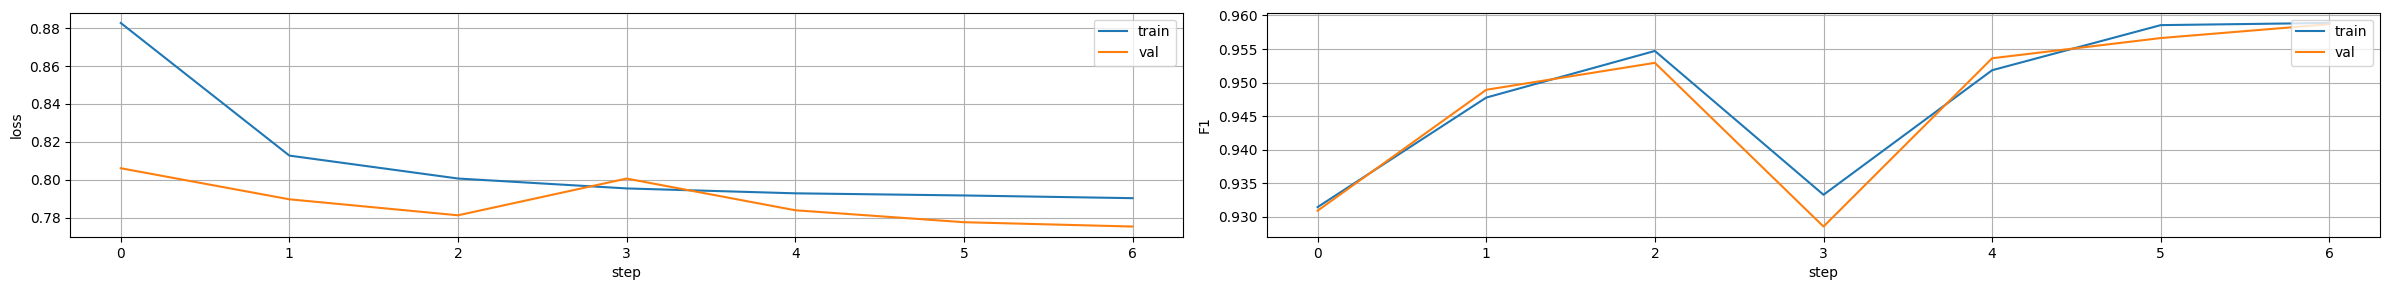

In [ ]:
from torchmetrics.classification import MulticlassF1Score
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainer.criterion = torch.nn.CrossEntropyLoss()
#trainer.criterion = torch.nn.BCELoss()
trainer.num_epochs = 20
trainer.optimizer = torch.optim.AdamW(trainer.model.parameters(), lr=0.001, weight_decay = 0.00001)
trainer.set_score_function(MulticlassF1Score(4), "F1")
trainer.fit()

In [ ]:
y_test_pred, _ = trainer.get_predictions(model=trainer.best_model, dl=test_loader)

In [ ]:
y_test_pred

In [ ]:
#s = pd.Series(list(y.tolist()))
#test_pr = pd.get_dummies(s)

s = pd.Series(y_test_pred)
test_pr = pd.get_dummies(s)

In [ ]:
test_pr.columns=['n1', 'n2', 'n3', 'n4']


In [ ]:
test_pr.to_csv('drive/MyDriveprediction_40.csv')

In [ ]:
test_pr